#Garbage Classification: A Comparative Analysis of Multi-Class Classification using Feature Descriptors and CNNs



This work is aimed at analyzing different techniques for the performance of a Multi-Calssification task, involving the classification of Garbage in 5 distinct classes: Glass, Paper, Cardboard, Plastic and Metal. The project objective is to address the classification problem using both Machine Learning and Deep Learning methods. Specifically, an initial classification will be performed using Feature Descriptors, and then the task will be performed using two CNNs, both pre-trained on ImageNet, comparing their architecture and metrics. The first CNN would be based on a MobileNet model, the second on VGG19.

### Import of the libraries

In [1]:
!pip install ImageHash

import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from os.path import join

import cv2
import sklearn
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from skimage.feature import hog, local_binary_pattern
from tqdm import tqdm

import os
from PIL import Image
import imagehash
import shutil

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.applications import ResNet50
import matplotlib.pyplot as plt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 7.7 MB/s eta 0:00:00


### Execution of random seed

This step is crucial to obtain deterministic (and replicable) results

In [2]:
np.random.seed(1583)

### Definition of the classes

Definition of the classes involved in the multi-classification task and the associated data labels

In [3]:
def get_labels(name):
    if 'glass' in name:
        return 0
    elif 'paper' in name:
        return 1
    elif 'cardboard' in name:
        return 2
    elif 'plastic' in name:
        return 3
    elif 'metal' in name:
        return 4
    else:
        raise NotImplementedError('Not existing class!')

### Definition of the feature extraction function
    
I use the function provided durign the lectures in laboratory. This function, besides extracting the features, allowing the selection the feature descriptor to use, enable the resizing of the input images and to return the data labels.

I've edited the image resizing function input, to enable the resizing of the image specifying both x and y.

In [4]:
def extract_features(images, feat_type, img_size):

    labels = []
    features = []

    for image in tqdm(images):

        # open the image
        img = cv2.imread(image, 0)

        # resize the image
        img = cv2.resize(img, (img_size[0], img_size[1]))

        # compute the features
        if feat_type == 'hog':
            feat = hog(img, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2))
        elif feat_type == 'lbp':
            feat = np.ravel(local_binary_pattern(img, P=100, R=5))
        elif feat_type == 'img':
            img = img / 256.0
            feat = np.ravel(img)
        else:
            raise NotImplementedError('Not implemented feature!')

        # append features and labels
        features.append(feat)
        labels.append(get_labels(image))

    return features, labels

# Machine Learning model: RandomForest multi-class classification with feature extraction

## 1. Data preparation

This phase has involved the splitting of the input dataset in training, validation and test sets.

In [5]:
!unzip -q Garbage_classification.zip -d /content

In [6]:
# population of the image list from the uploaded dataset
dataset_path = '/content/Garbage_classification'
images = glob(join(dataset_path, '*', '*.jpg'))

#extraction of the sole images belonging to

print('Images: ', len(images))

# re-shuffling of the dataset to avoid unintentional patterns or biases
np.random.shuffle(images)

Images:  2390


In [7]:
# subdivision of the dataset in train set (60%), validation set (10%), test set (30%)
trainset = images[:int(0.6*len(images))]
valset = images[int(0.6*len(images)):int(0.7*len(images))]
testset = images[int(0.7*len(images)):]
print('{} images splitted in train set ({}), validation set ({}) and test set ({})'.format(len(images), len(trainset), len(valset), len(testset)))

2390 images splitted in train set (1434), validation set (239) and test set (717)


## 2. Feature extraction
This step is aimed at exctracting a n-dimensional vector of numerical features, to be used as a simplified input to the Machine Learning model.

In this case I've used HOG (Histogram of Oriented Gradients) as I've observed better performances with respect to LBP

In [8]:
img_size = [224,224]
feature_type = 'hog'

train_x, train_y = extract_features(trainset, feature_type, img_size)
val_x, val_y = extract_features(valset, feature_type, img_size)
test_x, test_y = extract_features(testset, feature_type, img_size)

100%|██████████| 717/717 [00:19<00:00, 37.24it/s]


## 3. Model

In this section I've defined the model to be trained on the feature extracted in the previous phase: the Machine Learning algorithm employed is RandomForest, an ensemble classifier based on bagging, which uses Decision Trees as base classifiers.

**TRAINING**


In [18]:
clf = RandomForestClassifier(n_estimators = 500, verbose = 1)
clf.fit(train_x, train_y)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    6.3s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:   24.5s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:   55.8s


RandomForestClassifier(n_estimators=500, verbose=1)

**VALIDATION**

In [19]:
clf.score(val_x, val_y)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s


0.5439330543933054

## 4. Prediction and performance evaluation

For the evaluation of the model I've employed sklearn's `classification_record` function, that results some of the most relevant metrics for the measurement of the reliability of the classifier, such as accuracy, precision and recall, and `ConfusionMatrixDisplay` for the visualization of the classification matrix

In [20]:
y_pred = clf.predict(test_x)
print('Predicted {} samples'.format(len(y_pred)))
print('Final Accuracy: {:.3f}'.format(accuracy_score(test_y, y_pred)))

Predicted 717 samples
Final Accuracy: 0.579


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s


In [21]:
print(classification_report(test_y, y_pred, target_names=["glass", "paper", "cardboard", "plastic", "metal"]))

              precision    recall  f1-score   support

       glass       0.45      0.64      0.53       153
       paper       0.58      0.80      0.67       186
   cardboard       0.79      0.72      0.76        94
     plastic       0.63      0.39      0.48       155
       metal       0.63      0.31      0.42       129

    accuracy                           0.58       717
   macro avg       0.62      0.57      0.57       717
weighted avg       0.60      0.58      0.57       717



[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s


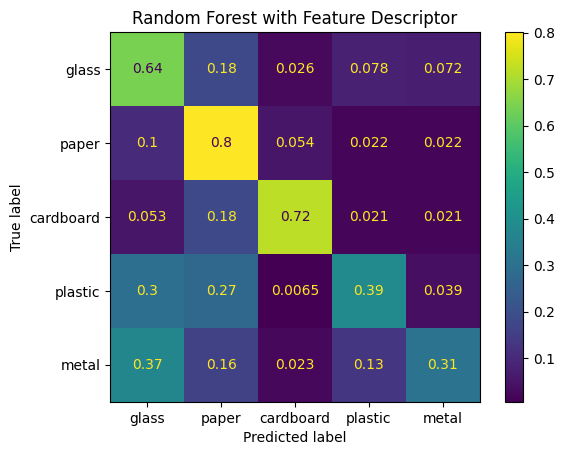

In [22]:
ConfusionMatrixDisplay.from_estimator(clf, test_x, test_y, normalize='true', display_labels=["glass", "paper", "cardboard", "plastic", "metal"])
plt.title("Random Forest with Feature Descriptor")
plt.show()

# Deep Learning models: MobileNet and VGG19 Convolutional Neural Networks


## 1. Data Preprocessing

In [23]:
!unzip -q Garbage_classification_DL.zip -d /content

The use of a Convolutional Neural Network to pursue the multi-classification task, forces us to use a larger amount of data.

I've decided to use another dataset for the training operation, different than the one used to train the Machine Learning model. This dataset has more images with respect with the other, but some of the images are shared in both the dataset.

It's crucial to ensure that the training set and the test set are well distinguished the one with the other and that they don't share images, otherwise the testing wouldn't be valid, as the model would be bias toward certain results.

I want to use the same testset used to test the Machine Learning model, but this involves the elimination of these images from the dataset I've identified as trainset.

Since the images in the train and test sets don't have the same name, although equal, I will compare their hash values.

To achieve the latter I defined two functions:

- `build_hash_dictionary`, that returns a dictionary of hashes and file paths of the images whose path is in the testset;
- `remove_testing_instances_from_trainset`, that given the testset and the path of the directory containing the images used for the trainset, removes the images whose hash value is in the dictionary

In [ ]:
def build_hash_dictionary(dataset):
    hash_dict = {}

    for file_path in dataset:
        # Generates the hash of the image
        with Image.open(file_path) as img:
            img_hash = str(imagehash.phash(img))

        # Adds the hash to the dictionary
        hash_dict.setdefault(img_hash, []).append(file_path)

    return hash_dict


In [ ]:
def remove_testing_instances_from_trainset(testset, training_dir):
    # Generates an hash dictionary of the images in the testset
    source_hash_dict = build_hash_dictionary(testset)

    drop_count = 0
    for classname in os.listdir(training_dir):
        for filename in os.listdir(os.path.join(training_dir, classname)):
            file_path = os.path.join(training_dir, classname, filename)

            # Generates the hash of the image
            with Image.open(file_path) as img:
                img_hash = str(imagehash.phash(img))

            # Checks if the hash is in the dictionary. If yes, it removes the image from the trainset
            if img_hash in source_hash_dict:
                os.remove(file_path)
                drop_count += 1

    print("Dropped {} test images from the trainset".format(drop_count))

In [ ]:
training_directory = "/content/Garbage_classification_DL"
remove_testing_instances_from_trainset(testset, training_directory)

Dropped 710 test images from the trainset


### Training set

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory='Garbage_classification_DL',
    labels='inferred',
    label_mode='categorical',
    class_names=["glass", "paper", "cardboard", "plastic", "metal"],
    color_mode='rgb',
    batch_size=32,
    image_size=(224,224),
    shuffle=True,
    seed=1821,
    validation_split=0.2,
    subset='training',
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 4876 files belonging to 5 classes.
Using 3901 files for training.


### Validation set

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory='Garbage_classification_DL',
    labels='inferred',
    label_mode='categorical',
    class_names=["glass", "paper", "cardboard", "plastic", "metal"],
    color_mode='rgb',
    batch_size=32,
    image_size=(224,224),
    shuffle=True,
    seed=1821,
    validation_split=0.2,
    subset='validation',
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 4876 files belonging to 5 classes.
Using 975 files for validation.


### Test set

To elaborate the test set using Keras I've decided to create a test dataset as a copy of the images that hae the path in the test set

The function `generate_test_folder` takes in input the testset and generate a folder with the test images.

In [ ]:
def generate_test_folder(testset):
    # Create the test folder
    os.makedirs("/content/Garbage_classification_DL_test", exist_ok=True)

    copy_count = 0
    # Iterate through the list of image paths in the testset
    for image_path in testset:
        _, _, _, class_folder, file_name = image_path.split(os.sep)

        # Create the destination subfolder for the images
        destination_subfolder = os.path.join("/content/Garbage_classification_DL_test", class_folder)
        os.makedirs(destination_subfolder, exist_ok=True)
        destination_path = os.path.join(destination_subfolder, file_name)

        # Copy the image to the destination path
        shutil.copy(image_path, destination_path)
        copy_count += 1

    print("Copied {} test images to /content/Garbage_classification_DL_test".format(copy_count))

In [ ]:
generate_test_folder(testset)

Copied 717 test images to /content/Garbage_classification_DL_test


In [ ]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory='Garbage_classification_DL_test',
    labels='inferred',
    label_mode='categorical',
    class_names=["glass", "paper", "cardboard", "plastic", "metal"],
    color_mode='rgb',
    batch_size=32,
    image_size=(224,224),
    shuffle=True,
    seed=1821,
    validation_split=0,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 717 files belonging to 5 classes.


## 2. Model architecture

Both the model architecture we're going to analyze are achitectures pre-trained on ImageNet




### 2.1 - MobileNet

In [ ]:
model = tf.keras.applications.MobileNet(
    input_shape=None,
    alpha=1.0,
    depth_multiplier=1,
    dropout=0.001,
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax"
)

output = Dense(5, activation='softmax', name='predictions')(model.layers[-2].output)
model = Model(model.input, output)

model.compile(
    optimizer=keras.optimizers.SGD(1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

**TRAINING**




In [ ]:
epochs = 10

callbacks = [
    keras.callbacks.ModelCheckpoint("MobileNet-save_at_{epoch}.h5")
]

model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/10
122/122 [==============================] - 26s 167ms/step - loss: 1.1851 - accuracy: 0.6793 - val_loss: 0.7662 - val_accuracy: 0.7836
Epoch 2/10
122/122 [==============================] - 20s 164ms/step - loss: 0.3919 - accuracy: 0.8662 - val_loss: 0.4927 - val_accuracy: 0.8410
Epoch 3/10
122/122 [==============================] - 20s 163ms/step - loss: 0.2571 - accuracy: 0.9116 - val_loss: 0.4264 - val_accuracy: 0.8523
Epoch 4/10
122/122 [==============================] - 20s 163ms/step - loss: 0.1675 - accuracy: 0.9444 - val_loss: 0.3844 - val_accuracy: 0.8728
Epoch 5/10
122/122 [==============================] - 20s 163ms/step - loss: 0.1396 - accuracy: 0.9474 - val_loss: 0.3580 - val_accuracy: 0.8728
Epoch 6/10
122/122 [==============================] - 21s 167ms/step - loss: 0.1050 - accuracy: 0.9656 - val_loss: 0.3530 - val_accuracy: 0.8851
Epoch 7/10
122/122 [==============================] - 20s 162ms/step - loss: 0.0905 - accuracy: 0.9718 - val_loss: 0.3316 - val_ac

**MODEL EVALUATION**

The `evaluate` function of a TensorFlow Keras model evaluates loss and accuracy of the trained model against a test set.

In [ ]:
model_trained = keras.models.load_model('/content/MobileNet-save_at_10.h5')

model_trained.evaluate(
    x=test_ds,
    y=None,
    batch_size=128,
    verbose=True,
    sample_weight=None,
    steps=None,
    callbacks=None,
    max_queue_size=10,
    workers=1,
    use_multiprocessing=False,
    return_dict=False,
)

23/23 [==============================] - 2s 42ms/step - loss: 0.5502 - accuracy: 0.8285


[0.550165057182312, 0.8284518718719482]

Besides the evaluation made with the build-in `evaluate` method of TensorFlow, I've obtained the prediction results, in order to compute the classification report and the confusion matrix.

The method `predict` returns the set of probabilities for the classes involved in the classification. This is the output of the last (Dense) layer

              precision    recall  f1-score   support

       glass       0.75      0.84      0.79       126
       paper       0.87      0.84      0.86       187
   cardboard       0.85      0.92      0.88       130
     plastic       0.84      0.77      0.80       149
       metal       0.83      0.76      0.79       125

    accuracy                           0.83       717
   macro avg       0.83      0.83      0.83       717
weighted avg       0.83      0.83      0.83       717



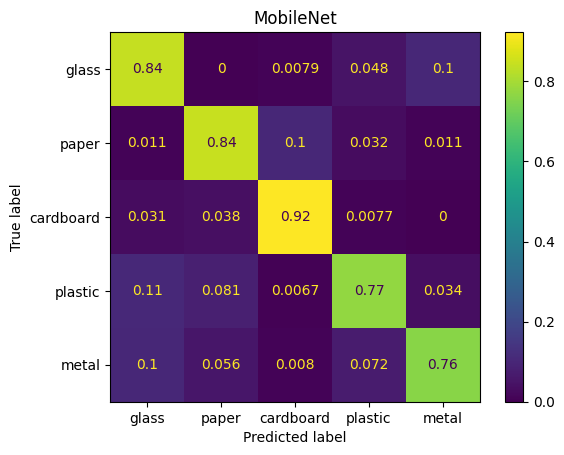

In [ ]:
y_predicted = np.array([])
y_actual =  np.array([])
for x, y in test_ds:
    y_predicted = np.concatenate([y_predicted, np.argmax(model_trained.predict(x, verbose=0), axis = -1)])
    y_actual = np.concatenate([y_actual, np.argmax(y.numpy(), axis=-1)])

# print the classification report
print(classification_report(y_actual, y_predicted, target_names=["glass", "paper", "cardboard", "plastic", "metal"]))

# Display the confusion matrix
ConfusionMatrixDisplay.from_predictions(y_actual, y_predicted, normalize="true", display_labels=["glass", "paper", "cardboard", "plastic", "metal"])
plt.title("MobileNet")
plt.show()

### 2.2 - **VGG19**




In [ ]:
model = tf.keras.applications.VGG19(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)

output = Dense(5, activation='softmax', name='predictions')(model.layers[-2].output)
model = Model(model.input, output)

model.compile(
    optimizer=keras.optimizers.SGD(1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

574710816/574710816 [==============================] - 11s 0us/step


**TRAINING**

In [ ]:
epochs = 5

callbacks = [
    keras.callbacks.ModelCheckpoint("VGG19-save_at_{epoch}.h5")
]

model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/5
122/122 [==============================] - ETA: 0s - loss: 0.5390 - accuracy: 0.8006

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


122/122 [==============================] - 117s 777ms/step - loss: 0.5390 - accuracy: 0.8006 - val_loss: 0.4221 - val_accuracy: 0.8379
Epoch 2/5
122/122 [==============================] - 87s 709ms/step - loss: 0.1528 - accuracy: 0.9472 - val_loss: 0.3256 - val_accuracy: 0.8862
Epoch 3/5
122/122 [==============================] - 87s 709ms/step - loss: 0.0485 - accuracy: 0.9874 - val_loss: 0.2993 - val_accuracy: 0.8985
Epoch 4/5
122/122 [==============================] - 73s 599ms/step - loss: 0.0116 - accuracy: 0.9987 - val_loss: 0.3281 - val_accuracy: 0.8995
Epoch 5/5
122/122 [==============================] - 79s 644ms/step - loss: 0.0067 - accuracy: 0.9992 - val_loss: 0.3350 - val_accuracy: 0.9036


**MODEL EVALUATION**

In [ ]:
model_trained = keras.models.load_model('/content/VGG19-save_at_5.h5')

model_trained.evaluate(
    x=test_ds,
    y=None,
    batch_size=32,
    verbose=True,
    sample_weight=None,
    steps=None,
    callbacks=None,
    max_queue_size=10,
    workers=1,
    use_multiprocessing=False,
    return_dict=False,
)

23/23 [==============================] - 4s 140ms/step - loss: 0.4621 - accuracy: 0.8605


[0.46207955479621887, 0.8605299592018127]

              precision    recall  f1-score   support

       glass       0.77      0.86      0.81       126
       paper       0.90      0.88      0.89       187
   cardboard       0.88      0.91      0.89       130
     plastic       0.88      0.79      0.83       149
       metal       0.87      0.87      0.87       125

    accuracy                           0.86       717
   macro avg       0.86      0.86      0.86       717
weighted avg       0.86      0.86      0.86       717



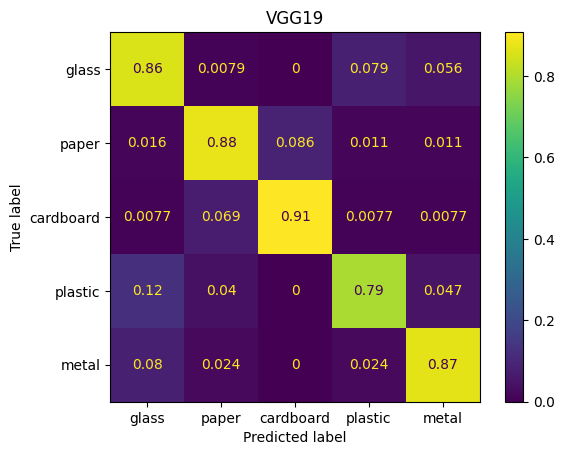

In [ ]:
y_predicted = np.array([])
y_actual =  np.array([])
for x, y in test_ds:
    y_predicted = np.concatenate([y_predicted, np.argmax(model_trained.predict(x, verbose=0), axis = -1)])
    y_actual = np.concatenate([y_actual, np.argmax(y.numpy(), axis=-1)])

# print the classification report
print(classification_report(y_actual, y_predicted, target_names=["glass", "paper", "cardboard", "plastic", "metal"]))

# Display the confusion matrix
ConfusionMatrixDisplay.from_predictions(y_actual, y_predicted, normalize="true", display_labels=["glass", "paper", "cardboard", "plastic", "metal"])
plt.title("VGG19")
plt.show()